### Your name:

<pre> Derek Pyne </pre>

### Collaborators:

<pre> None </pre>


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### TensorFlow

Q1. When is a variable initialized? When is it destroyed?

A variable is initialized when it's initializer is run and is destroyed when the session is closed. It can persist across graph runs within a single session.

Q2. What is the difference between a placeholder and a variable?

Variables are used to store values within a graph such as weights, outputs ect. Placeholders are used to feed data into the algorithm. They don't perform any computation but just output the data they are told to at runtime. They are useful for online or minibatch learning.

Q3. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

- Reverse-mode autodiff: 11
- Forward-mode autodiff: number of inputs
- Symbolic differention: Not applicable. Does not traverse the graph. Looks to see if an actual symbolic derivative can be found (can be extrodinarily difficult).

Q4. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using name scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

# Implementation
First let's make a moons dataset.

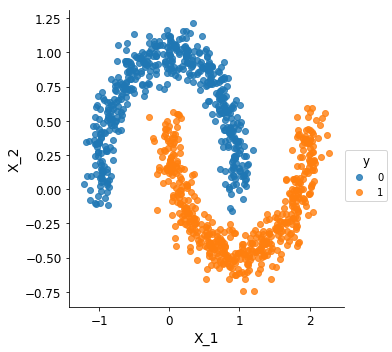

In [2]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

df = pd.DataFrame({'X_1': X_moons[:,0], 'X_2': X_moons[:,1], 'y': y_moons})
sns.lmplot('X_1', 'X_2', df, hue='y', fit_reg=False)

We can now define our Logistic Regression model in Tensorflow. We will use Placeholders for mini-batch gradient descent, use a Saver to save our progress and log stats for TensorBoard.

Since we are just interested in getting started with Tensorflow here, we will not bother to set up any test/train setup and will instead just look at the training error.

In [3]:
import os
from datetime import datetime
import logging

def fetch_batch(X, y, batch_index, batch_size):
    X_batch = X[batch_index*batch_size:(batch_index+1)*batch_size, :]
    y_batch = y[batch_index*batch_size:(batch_index+1)*batch_size].reshape(-1, 1)
    return X_batch, y_batch

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def logistic_regression(X_data, 
                        y_data, 
                        learning_rate = .01, 
                        n_epochs = 1000, 
                        batch_size = 100,
                        prob_threshold = 0.5,
                        log_level=logging.CRITICAL,
                        restore=False):
    m, n = X_data.shape
    n_batches = int(np.ceil(m / batch_size))
    X_data_plus_bias = np.c_[np.ones((X_data.shape[0], 1)), X_data]
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
            y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

            theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
            y_prob = tf.sigmoid(tf.matmul(X, theta), name="pred_probability")
            y_pred = y_prob > prob_threshold

        with tf.name_scope("training"):
            cost = tf.losses.log_loss(y, y_prob) 

            loss_summary = tf.summary.scalar('log_loss', cost)
            file_writer = tf.summary.FileWriter(log_dir('tensorboard_logs'), tf.get_default_graph())

            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(cost)

        with tf.name_scope("saver"):
            saver = tf.train.Saver()
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
    with tf.Session() as sess:
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir="tf_checkpoints"))
        else:
            sess.run(init)        
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_data_plus_bias, y_data, batch_index, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            cost_val, predictions, summary_str = sess.run([cost, y_pred, loss_summary], feed_dict={X: X_data_plus_bias, y: y_data})
    
            if epoch % 100 == 0:
                if log_level <= logging.INFO: print("Epoch %s: Cost = %s" % (epoch, cost_val))
                file_writer.add_summary(summary_str, epoch)
                saver.save(sess, "tf_checkpoints/logistic_regression", global_step=epoch)
        
    return predictions

predictions = logistic_regression(X_moons, y_moons.reshape(-1, 1), log_level=logging.INFO)

Epoch 0: Cost = 0.616135
Epoch 100: Cost = 0.410257
Epoch 200: Cost = 0.351674
Epoch 300: Cost = 0.322045
Epoch 400: Cost = 0.303754
Epoch 500: Cost = 0.291418
Epoch 600: Cost = 0.282683
Epoch 700: Cost = 0.276291
Epoch 800: Cost = 0.271494
Epoch 900: Cost = 0.267818


Plotting our result we see that our model fit the data reasonably well considering it is a linear classifier.

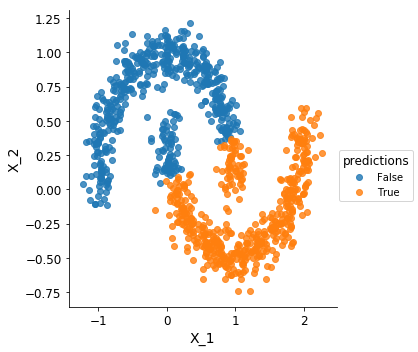

In [4]:
df = pd.DataFrame({'X_1': X_moons[:,0], 'X_2': X_moons[:,1], 'predictions': np.ravel(predictions)})
sns.lmplot('X_1', 'X_2', df, hue='predictions', fit_reg=False)

We can adjust some hyperparameters using a small convenience function to let us iterate over possible values easily.

In [5]:
def evaluate_tensor_model(model, X, y, scoring_function, parameters):
    y_pred = model(X, y, **parameters)
    score = scoring_function(y, y_pred)
    return score

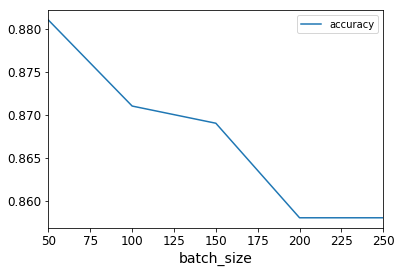

In [6]:
from sklearn.metrics import accuracy_score

df_batch_size = pd.DataFrame({"batch_size": range(50,300,50)})

df_batch_size['accuracy'] = df_batch_size['batch_size']\
    .apply(lambda batch_size: evaluate_tensor_model(logistic_regression, X_moons, y_moons.reshape(-1, 1), 
                                                    accuracy_score, {'batch_size':batch_size}))
df_batch_size.plot(x='batch_size', y='accuracy')

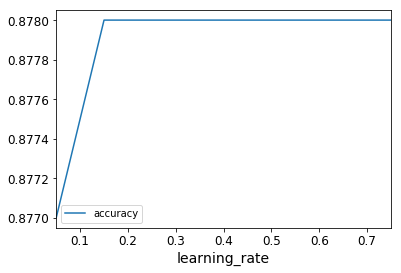

In [7]:
df_learning_rate = pd.DataFrame({"learning_rate": np.arange(.05, .8, .1)})

df_learning_rate['accuracy'] = df_learning_rate['learning_rate']\
    .apply(lambda learning_rate: evaluate_tensor_model(logistic_regression, X_moons, y_moons.reshape(-1, 1), 
                                                    accuracy_score, {'learning_rate':learning_rate}))
df_learning_rate.plot(x='learning_rate', y='accuracy')

Q5. Similar to the linear regression implementation in class, write a lasso regression implementation. Use the same dataset, and choose a value for the penalty $\alpha$:

Using a Saver at regular intervals during training, and save the final model at the end of training.

Restore the last checkpoint upon startup if training was interrupted.

Define the graph using name scopes so the graph looks good in TensorBoard.

Add summaries to visualize the learning curves in TensorBoard.

Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [8]:
def lasso_regression(X_data, 
                        y_data, 
                        learning_rate = .01, 
                        n_epochs = 1000, 
                        batch_size = 100,
                        alpha = 0.5,
                        log_level=logging.CRITICAL,
                        restore=False):
    m, n = X_data.shape
    n_batches = int(np.ceil(m / batch_size))
    X_data_plus_bias = np.c_[np.ones((X_data.shape[0], 1)), X_data]
    
    with tf.name_scope("lasso_regression"):
        with tf.name_scope("model"):
            X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
            y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

            theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
            y_pred = tf.matmul(X, theta)
        with tf.name_scope("training"):
            lasso_cost = tf.reduce_sum(tf.abs(theta))

            cost = tf.losses.mean_squared_error(y, y_pred) + lasso_cost

            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(cost)
            
            loss_summary = tf.summary.scalar('lasso_loss', cost)
            file_writer = tf.summary.FileWriter(log_dir('tensorboard_logs'), tf.get_default_graph())
        with tf.name_scope("saver"):
            saver = tf.train.Saver()
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
    with tf.Session() as sess:
        
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir="tf_checkpoints"))
        else:
            sess.run(init)
            
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_data_plus_bias, y_data, batch_index, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

            cost_val, predictions, summary_str = sess.run([cost, y_pred, loss_summary], feed_dict={X: X_data_plus_bias, y: y_data})
    
            if epoch % 100 == 0:
                if log_level <= logging.INFO: print("Epoch %s: Cost = %s" % (epoch, cost_val))
                file_writer.add_summary(summary_str, epoch)
                saver.save(sess, "tf_checkpoints/lasso_regression", global_step=epoch)
        
    return predictions
predictions = lasso_regression(X_moons, y_moons.reshape(-1, 1), log_level=2)

Epoch 0: Cost = 1.4207
Epoch 100: Cost = 0.507877
Epoch 200: Cost = 0.50928
Epoch 300: Cost = 0.508321
Epoch 400: Cost = 0.5067
Epoch 500: Cost = 0.504585
Epoch 600: Cost = 0.502057
Epoch 700: Cost = 0.500628
Epoch 800: Cost = 0.502324
Epoch 900: Cost = 0.504582


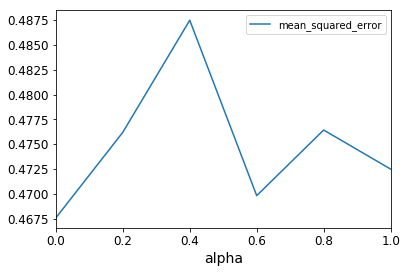

In [9]:
from sklearn.metrics import mean_squared_error
df_alpha = pd.DataFrame({"alpha": [0, .2, .4, .6, .8, 1]})

df_alpha['mean_squared_error'] = df_alpha['alpha']\
    .apply(lambda alpha: evaluate_tensor_model(lasso_regression, X_moons, y_moons.reshape(-1, 1), 
                                                    mean_squared_error, {'alpha':alpha}))
df_alpha.plot(x='alpha', y='mean_squared_error')

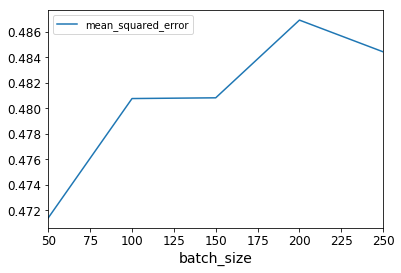

In [10]:
df_batch_size = pd.DataFrame({"batch_size": range(50,300,50)})

df_batch_size['mean_squared_error'] = df_batch_size['batch_size']\
    .apply(lambda batch_size: evaluate_tensor_model(lasso_regression, X_moons, y_moons.reshape(-1, 1), 
                                                    mean_squared_error, {'batch_size':batch_size}))
df_batch_size.plot(x='batch_size', y='mean_squared_error')